# Obligatorio de Deep Learning: Detección de actividad anormal en logs de HDFS

Federico De León  
Daniel Dominitz  
Juan Emilio Gabito (138616)

## 1. Setup

### Imports

In [ ]:
# Si estamos en Colab setemos Drive como FS
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Para Colab nos paramos en alguna de las carpetas del grupo
import os
if os.path.exists("/content/drive/MyDrive/ORT/DeepLearning/Obligatorio"):
  os.chdir('/content/drive/MyDrive/ORT/DeepLearning/Obligatorio')
else:
  if os.path.exists("/content/drive/MyDrive/ORT/Posgrado AI/Taller DeepLearning/Obligatorio"):
    os.chdir("/content/drive/MyDrive/ORT/Posgrado AI/Taller DeepLearning/Obligatorio")

In [ ]:
import numpy as np
import datetime as dt
import math
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Embedding, LSTM, Dense, BatchNormalization
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from importlib import reload
import utils
utils = reload(utils)

import pandas as pd

### Reproducibilidad y repetibilidad

Para poder asegurar la reproducibilidad y repetibilidad de los experimentos en distintas ejecuciones seteamos la _seed_ tanto en Numpy como en Tensorflow.

In [ ]:
np.random.seed(117)
tf.random.set_seed(117)

## 2. Carga de datos

In [ ]:
hdfs_train, hdfs_test_kaggle = utils.read_data()

In [ ]:
hdfs_train[:4]

,id,sequence,class
0,0,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal
1,1,"(4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,...",normal
2,2,"(21, 4, 4, 4, 25, 25, 10, 8, 25, 10, 8, 10, 8,...",normal
3,3,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal


In [ ]:
hdfs_test_kaggle[:5]

,id,sequence
0,0,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25)"
1,1,"(4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,..."
2,2,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,..."
3,3,"(4, 4, 4, 21, 10, 8, 10, 8, 25, 25, 25, 10, 8,..."
4,4,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,..."


## 3. Análisis exploratorio de datos

### Análisis descriptivo general

In [ ]:
hdfs_train.head()

,id,sequence,class
0,0,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal
1,1,"(4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,...",normal
2,2,"(21, 4, 4, 4, 25, 25, 10, 8, 25, 10, 8, 10, 8,...",normal
3,3,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal
4,4,"(21, 4, 4, 4, 25, 25, 25, 10, 8, 10, 8, 10, 8,...",normal


In [ ]:
LABELS = ['Normal', 'Abnormal']

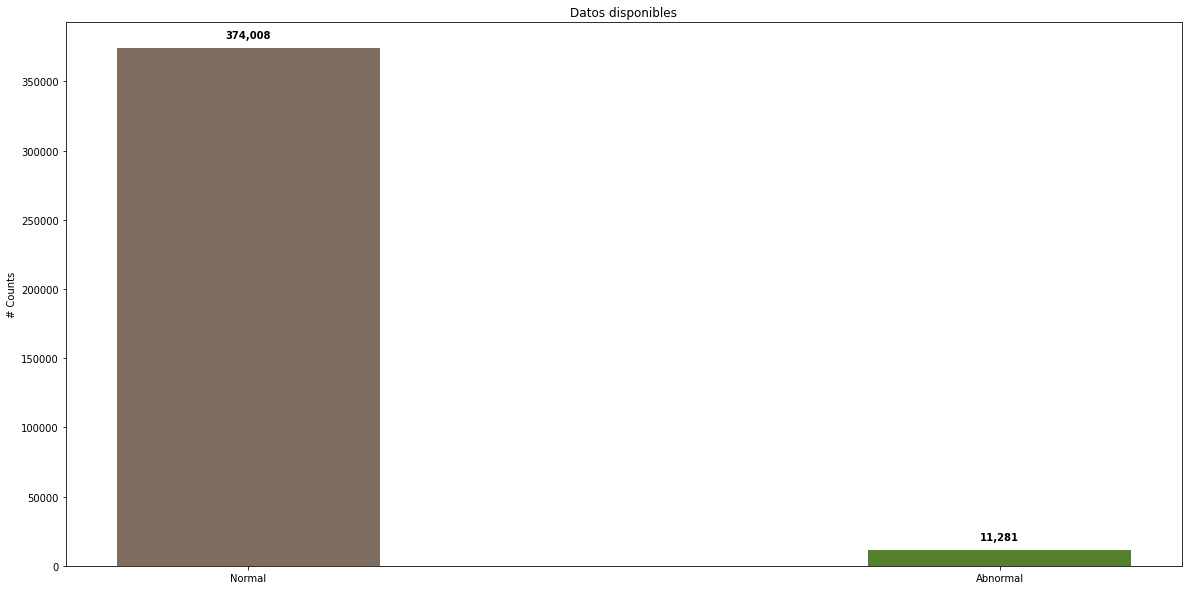

In [ ]:
utils.plot_data(hdfs_train, LABELS, "Datos disponibles")

### Análisis de secuencias

In [ ]:
#Agregar ploteo de largos de secuencias, distribuciones por simbolo, etc.

In [ ]:
raw_sequences, data_y = utils.load_sequences_and_target(hdfs_train, one_hot=True)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
data_y.value_counts()

0         1       
0.000%    100.000%    374008
100.000%  0.000%       11281
dtype: int64

In [ ]:
min([min(s) for s in raw_sequences])

1

In [ ]:
max([max(s) for s in raw_sequences])

28

In [ ]:
np.median([len(s) for s in raw_sequences])

19.0

In [ ]:
# Deberíamos agregar la mean también

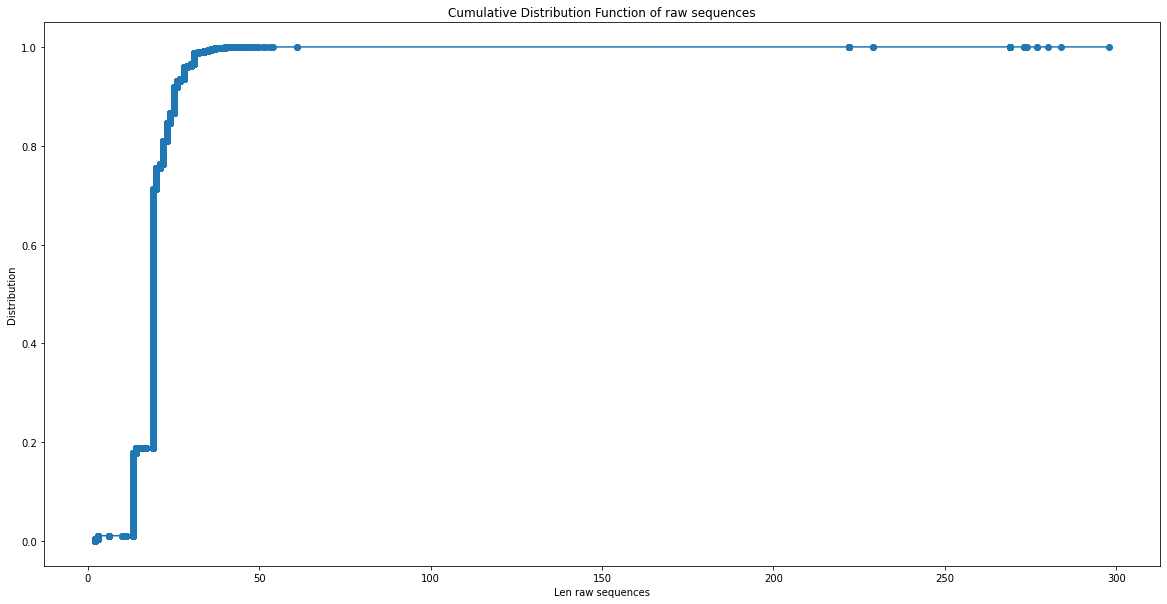

In [ ]:
# Esto no tengo ni idea qué es. ¿Qué aporta? ¿Es parte del EDA?
# get the cdf values of the len
y = np.arange(len([len(s) for s in raw_sequences])) / float(len([len(s) for s in raw_sequences]))

#fig size
plt.figure(figsize=(20,10)) 
#labels
plt.xlabel('Len raw sequences')
plt.ylabel('Distribution')
#title
plt.title('Cumulative Distribution Function of raw sequences')  
#plot 
plt.plot(np.sort([len(s) for s in raw_sequences]), y, marker='o')

# Preprocesamiento de los datos

Previo a realizar el preprocesamiento de los datos y el posterior entrenamiento y evaluación se los modelos setearemos la constante
_MAX\_LEN_ en 19. Este valor se obtuvo del largo promedio de las secuencias y en base a experimentación con
tamaños maores y menores se pudo ver que 19 ofrecía los mejores resultados.

In [ ]:
MAX_LEN = 19

## Padding

In [ ]:
padded_sequences = utils.pad_sequences(raw_sequences, MAX_LEN)

## Particionamiento

In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = utils.split(padded_sequences, data_y)

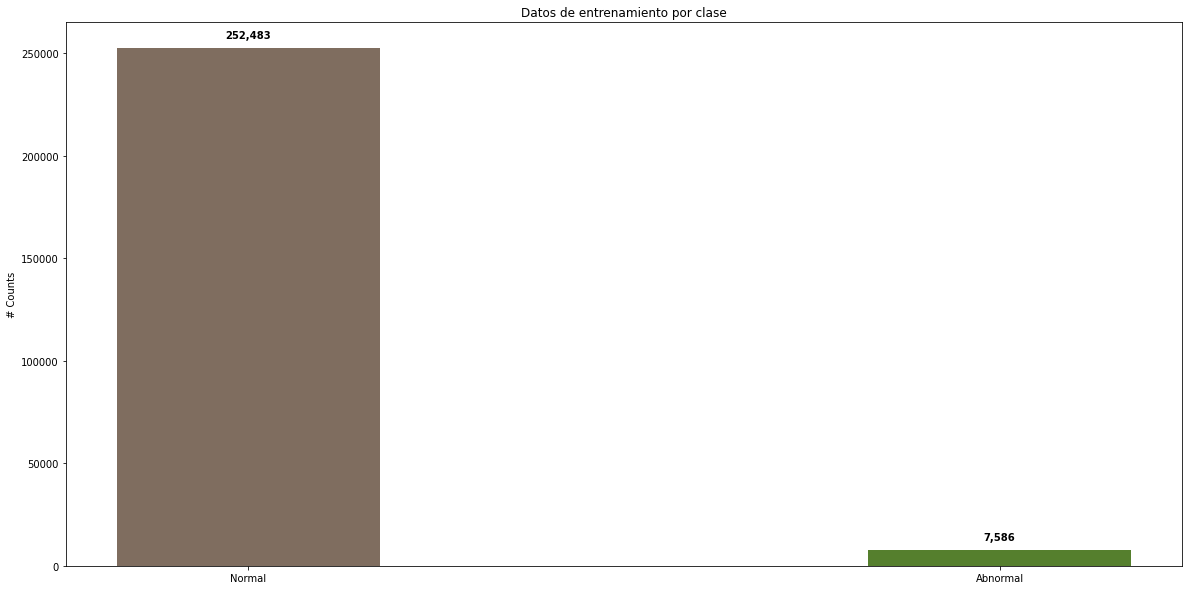

In [ ]:
utils.plot_data(y_train, LABELS, "Datos de entrenamiento por clase", has_class=False)


## Generación de datos con Data Augmentation

In [ ]:
X_train_for_aug, dummy_a, dummy_b, dummy_c, dummy_d, dummy_e = utils.split(raw_sequences, data_y)

In [ ]:
# Fijamos la cantidad de ventanas para el data augmentation
WINDOWS = 3

In [ ]:
X_train_aug, y_train_aug = utils.sequences_augmentation(X_train_for_aug, y_train, MAX_LEN, WINDOWS)

In [ ]:
"""
padding to data augmentation train
"""
X_train_aug = utils.pad_sequences(X_train_aug, MAX_LEN)

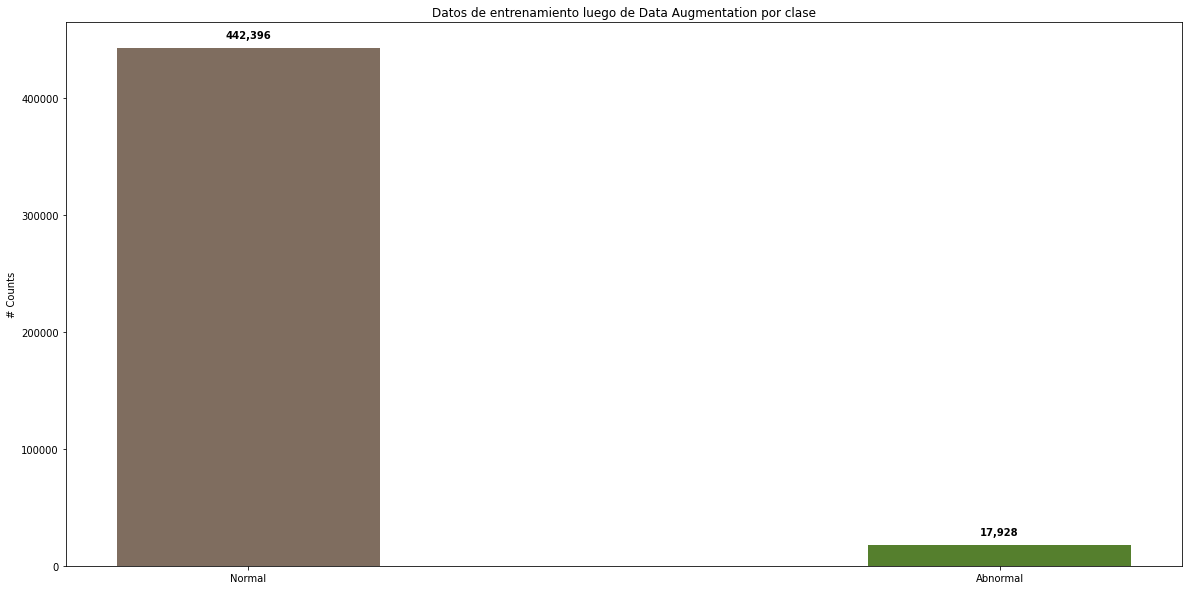

In [ ]:
utils.plot_data(y_train_aug, LABELS, "Datos de entrenamiento luego de Data Augmentation por clase", has_class=False)

# Redes Neuronales Recurrentes

## Modelo Inicial

In [ ]:
vocab_size = max([max(s) for s in raw_sequences]) + 1
batch_size = 10
epochs = 2
patience = 5
optimizer = Adam() 
loss = 'categorical_crossentropy'
embedding_size = math.ceil(vocab_size**0.25) 

### Truncating = 'Pre'

In [ ]:
initial_model = Sequential()
initial_model.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
initial_model.add(LSTM(64, return_sequences=False))
initial_model.add(Dense(2, activation='softmax'))
initial_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
initial_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 19, 3)             90        
                                                                 
 lstm_4 (LSTM)               (None, 64)                17408     
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 17,628
Trainable params: 17,628
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento

In [ ]:
#se agregó class.weights
initial_training, initial_model = utils.train(initial_model,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/2
26007/26007 [==============================] - 336s 13ms/step - loss: 0.0549 - accuracy: 0.9909 - val_loss: 0.0104 - val_accuracy: 0.9985
Epoch 2/2
26007/26007 [==============================] - 332s 13ms/step - loss: 0.0153 - accuracy: 0.9981 - val_loss: 0.0101 - val_accuracy: 0.9992


#### Evaluación

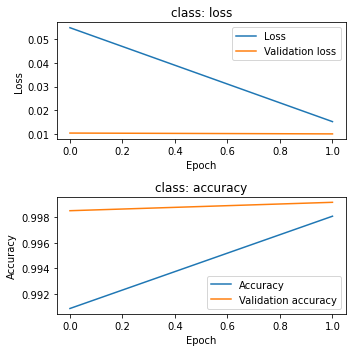

3011/3011 [==============================] - 15s 5ms/step


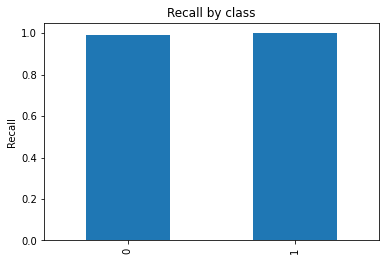

Classification report
              precision    recall  f1-score   support

    abnormal       0.97      0.99      0.98      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.99      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.011026093736290932, accuracy: 0.9989929795265198


In [ ]:
initialmodel_accuracy, initialmodel_precision, initialmodel_recall, initialmodel_f1 = utils.eval_model(initial_training, initial_model, X_test, y_test)

### Truncating = 'Post'

In [ ]:
initial_model_post = Sequential()
initial_model_post.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
initial_model_post.add(LSTM(64, return_sequences=False))
initial_model_post.add(Dense(2, activation='softmax'))
initial_model_post.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
initial_model_post.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 19, 3)             90        
                                                                 
 lstm_5 (LSTM)               (None, 64)                17408     
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                                 
Total params: 17,628
Trainable params: 17,628
Non-trainable params: 0
_________________________________________________________________


#### Datos con padding al final

In [ ]:
padded_sequences_post = utils.pad_sequences(raw_sequences, MAX_LEN,truncating='post')

In [ ]:
X_train_post, X_test_post, X_val_post, y_train_post, y_test_post, y_val_post = utils.split(padded_sequences_post, data_y)

#### Entrenamiento

In [ ]:
#se agregó class.weights
initial_training_post, initial_model_post = utils.train(initial_model_post,
                X_train_post,
                y_train_post, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val_post, 
                validation_data_y = y_val_post,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/2
26007/26007 [==============================] - 322s 12ms/step - loss: 0.2661 - accuracy: 0.9807 - val_loss: 0.1717 - val_accuracy: 0.9909
Epoch 2/2
26007/26007 [==============================] - 318s 12ms/step - loss: 0.2417 - accuracy: 0.9895 - val_loss: 0.1966 - val_accuracy: 0.9909


#### Evaluación

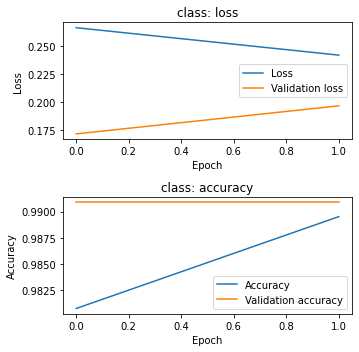

3011/3011 [==============================] - 14s 5ms/step


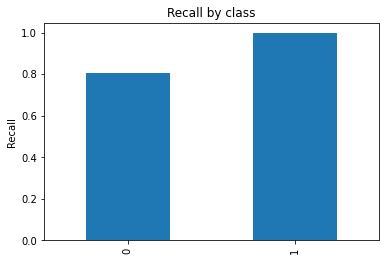

Classification report
              precision    recall  f1-score   support

    abnormal       0.89      0.81      0.85      2901
      normal       0.99      1.00      1.00     93422

    accuracy                           0.99     96323
   macro avg       0.94      0.90      0.92     96323
weighted avg       0.99      0.99      0.99     96323

Loss function: 0.19640564918518066, accuracy: 0.9912170767784119


In [ ]:
initialmodel_post_accuracy, initialmodel_post_precision, initialmodel_post_recall, initialmodel_post_f1 = utils.eval_model(initial_training_post, initial_model_post, X_test_post, y_test_post)

### Comentarios padding

In [ ]:
pd.options.display.float_format = '{:.3%}'.format
data = [['Initial Model Pre Truncating',initialmodel_accuracy, initialmodel_precision, initialmodel_recall, initialmodel_f1], ['Initial Model Post Truncating',initialmodel_post_accuracy, initialmodel_post_precision, initialmodel_post_recall, initialmodel_post_f1]]
pd.DataFrame(data, columns=["Modelo", "Accuracy", "Precision","Recall","F1-score"]).sort_values(by='F1-score', ascending=False)

## Modelo Mejorado

In [ ]:
vocab_size = max([max(s) for s in raw_sequences]) + 1
batch_size = 24
epochs = 7
patience = 5
optimizer = Adam() 
loss = 'categorical_crossentropy'
embedding_size = math.ceil(vocab_size**0.25) 

In [ ]:
improved_model = Sequential()
improved_model.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
improved_model.add(LSTM(64, return_sequences=True))
improved_model.add(LSTM(64, return_sequences=False))
improved_model.add(Dense(2, activation='softmax'))
improved_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
improved_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 19, 3)             90        
                                                                 
 lstm_6 (LSTM)               (None, 19, 64)            17408     
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 50,652
Trainable params: 50,652
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento

In [ ]:
#se agregó class.weights
improved_training, improved_model = utils.train(improved_model,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/7
10837/10837 [==============================] - 283s 26ms/step - loss: 0.0499 - accuracy: 0.9922 - val_loss: 0.0087 - val_accuracy: 0.9989
Epoch 2/7
10837/10837 [==============================] - 275s 25ms/step - loss: 0.0153 - accuracy: 0.9981 - val_loss: 0.0189 - val_accuracy: 0.9965
Epoch 3/7
10837/10837 [==============================] - 281s 26ms/step - loss: 0.0192 - accuracy: 0.9969 - val_loss: 0.0054 - val_accuracy: 0.9988
Epoch 4/7
10837/10837 [==============================] - 272s 25ms/step - loss: 0.0130 - accuracy: 0.9984 - val_loss: 0.0077 - val_accuracy: 0.9988
Epoch 5/7
10837/10837 [==============================] - 266s 25ms/step - loss: 0.0109 - accuracy: 0.9987 - val_loss: 0.0041 - val_accuracy: 0.9993
Epoch 6/7
10837/10837 [==============================] - 267s 25ms/step - loss: 0.0097 - accuracy: 0.9989 - val_loss: 0.0067 - val_accuracy: 0.9987
Epoch 7/7
10837/10837 [==============================] - 267s 25ms/step - loss: 0.0101 - accuracy: 0.9990 - val_

### Evaluación

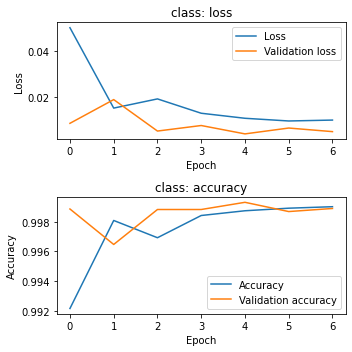

3011/3011 [==============================] - 26s 8ms/step


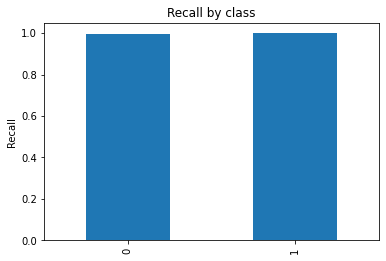

Classification report
              precision    recall  f1-score   support

    abnormal       0.96      0.99      0.98      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.98      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.005752459168434143, accuracy: 0.9987126588821411


In [ ]:
improved_model_accuracy, improved_model_precision, improved_model_recall, improved_model_f1 = utils.eval_model(improved_training, improved_model, X_test, y_test)

## Grid Search



In [ ]:
vocab_size = 30
patience = 5
embedding_size=3

params = {
    "batch_size": [16, 32],
    "epochs": [2, 8, 15],
    "units": [2,64, 72],
    "vocab_size": [vocab_size + 1,],
    "embedding_size": [embedding_size],
    "max_len": [MAX_LEN,],
    "optimizer": ["adam",],
    "loss": ["categorical_crossentropy",]
}

In [ ]:
"""
Entrenamiento
"""
gs = utils.grid_search(params, utils.build_improved_model, 3)
grid_result = gs.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
best_params = {'batch_size': 32,
 'embedding_size': 3,
 'epochs': 15,
 'loss': 'categorical_crossentropy',
 'max_len': 19,
 'optimizer': 'adam',
 'units': 72,
 'vocab_size': 31}

In [ ]:
# grid_result.best_params_ #comentar que tambien se puede obtener el best model que en definitiva es lo mismo que hacemos en Modelo Mejorado
best_params

{'batch_size': 32,
 'embedding_size': 3,
 'epochs': 15,
 'loss': 'categorical_crossentropy',
 'max_len': 19,
 'optimizer': 'adam',
 'units': 72,
 'vocab_size': 31}

In [ ]:
# batch_size = grid_result.best_params_['vocab_size']
# epochs = grid_result.best_params_['epochs']
# units = grid_result.best_params_['units']
# optimizer = Adam() 
# loss = grid_result.best_params_['loss']

batch_size = best_params['vocab_size']
epochs = best_params['epochs']
units = best_params['units']
optimizer = Adam() 
loss = best_params['loss']

### Model Mejorado 

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
model.add(LSTM(units, return_sequences=True))
model.add(LSTM(units, return_sequences=False))
model.add(Dense(2, activation='softmax'))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 19, 3)             90        
                                                                 
 lstm_8 (LSTM)               (None, 19, 72)            21888     
                                                                 
 lstm_9 (LSTM)               (None, 72)                41760     
                                                                 
 dense_6 (Dense)             (None, 2)                 146       
                                                                 
Total params: 63,884
Trainable params: 63,884
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento

In [ ]:
#se agregó class.weights
training, model = utils.train(model,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/15
8390/8390 [==============================] - 250s 29ms/step - loss: 0.0477 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - val_loss: 0.0092 - val_accuracy: 0.9984 - val_precision: 0.9984 - val_recall: 0.9984
Epoch 2/15
8390/8390 [==============================] - 245s 29ms/step - loss: 0.0174 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - val_loss: 0.0193 - val_accuracy: 0.9963 - val_precision: 0.9963 - val_recall: 0.9963
Epoch 3/15
8390/8390 [==============================] - 243s 29ms/step - loss: 0.0195 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - val_loss: 0.0124 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983
Epoch 4/15
8390/8390 [==============================] - 244s 29ms/step - loss: 0.0132 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - val_loss: 0.0101 - val_accuracy: 0.9962 - val_precision: 0.9962 - val_recall: 0.9962
Epoch 5/15
8390/8390 [==============================] - 245s 29ms/step - loss: 0.010

#### Evaluación

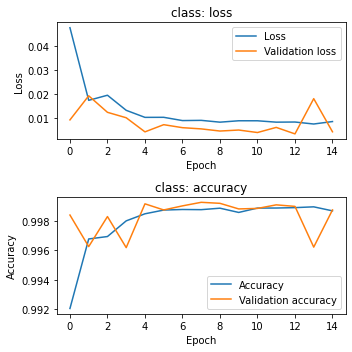

3011/3011 [==============================] - 28s 9ms/step


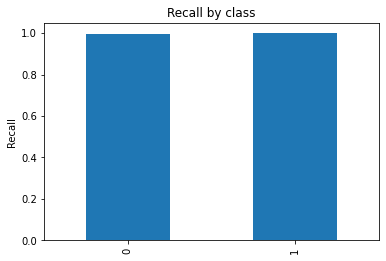

Classification report
              precision    recall  f1-score   support

    abnormal       0.96      0.99      0.98      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.98      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.004199494607746601, accuracy: 0.9987126588821411


In [ ]:
model_accuracy, model_precision, model_recall, model_f1 = utils.eval_model(training, model, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [ ]:
name='model'

"""
Generate data Kaggle
"""
#generate kaggle
utils.load_test_sequences_and_generate_prediction_file(model, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = model.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

5931/5931 [==============================] - 55s 9ms/step
Saved model to disk


### Modelo Mejorado con Batch Normalization

Segun Browlee: Batch Normalization (BN) es una técnica para entrenar redes neuronales muy profundas que estandariza las entradas a cada capa para cada mini batch. Esto tiene el efecto de estabilizar el proceso de aprendizaje y reducir drásticamente la cantidad de epochs en train necesarias para entrenar una red.

Los beneficios de aplicarla, son:
- Entrenamiento más rápido: aunque cada iteración será más lenta debido al cálculo de las normalizaciones aplicadas, se logra una convergencia mucho más rápida y ende, el entrenamiento en términos generales debería de ser más rápido.
- Mayor learning rate: el descenso de gradiente, generalmente, requiere pequeñas tasas de aprendizaje para lograr llegar a una convergencia. A medida que las redes se vuelven más profundas, los gradientes se vuelven más pequeños durante la retropropagación y, por lo tanto, requieren aún más iteraciones. El uso de BN permite tasas de aprendizaje mucho más altas, lo que aumenta la velocidad de train.

- Inicializar los weights es más fácil: la inicialización de los weights es más difícil a medida que se crean redes más profundas. BN logra reducir la sensibilidad a los pesos iniciales.

Además de lo anterior, en algunos casos se logra una mejora en el rendimiento del modelo a través de un modesto efecto de regularización.

In [ ]:
modelBN = Sequential()
modelBN.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
modelBN.add(LSTM(units, return_sequences=True))
modelBN.add(LSTM(units, return_sequences=False))
modelBN.add(BatchNormalization())
modelBN.add(Dense(2, activation='softmax'))
modelBN.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelBN.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 19, 3)             90        
                                                                 
 lstm_10 (LSTM)              (None, 19, 72)            21888     
                                                                 
 lstm_11 (LSTM)              (None, 72)                41760     
                                                                 
 batch_normalization (BatchN  (None, 72)               288       
 ormalization)                                                   
                                                                 
 dense_7 (Dense)             (None, 2)                 146       
                                                                 
Total params: 64,172
Trainable params: 64,028
Non-trainable params: 144
________________________________________________

La implementación en Keras de BN consiste solo en agregar una layer en nuestro modelo y con esto, aplicamos una transformación que mantiene la salida media cercana a 0 y la desviación estándar de salida cercana a 1.

En nuestro y tal como se sugiere en el [paper original](https://arxiv.org/pdf/1502.03167.pdf), agregamos la layer de BN previo a la función de activación. Pero, tal como sugiere Brownlee hay algunos [experimentos](https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md) que demuestran una mejor performance aplicándola luego de la función de activación. Nos quedó pendiente realizar el testeo en nuestro caso para determinar cual nos es más conveniente.

#### Entrenamiento

In [ ]:
#se agregó class.weights
trainingBN, modelBN = utils.train(modelBN,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/15
8390/8390 [==============================] - 256s 30ms/step - loss: 0.0334 - accuracy: 0.9944 - precision_1: 0.9944 - recall_1: 0.9944 - val_loss: 0.0583 - val_accuracy: 0.9989 - val_precision_1: 0.9989 - val_recall_1: 0.9989
Epoch 2/15
8390/8390 [==============================] - 250s 30ms/step - loss: 0.0175 - accuracy: 0.9979 - precision_1: 0.9979 - recall_1: 0.9979 - val_loss: 0.0055 - val_accuracy: 0.9993 - val_precision_1: 0.9993 - val_recall_1: 0.9993
Epoch 3/15
8390/8390 [==============================] - 252s 30ms/step - loss: 0.0162 - accuracy: 0.9983 - precision_1: 0.9983 - recall_1: 0.9983 - val_loss: 0.0104 - val_accuracy: 0.9989 - val_precision_1: 0.9989 - val_recall_1: 0.9989
Epoch 4/15
8390/8390 [==============================] - 252s 30ms/step - loss: 0.0138 - accuracy: 0.9984 - precision_1: 0.9984 - recall_1: 0.9984 - val_loss: 0.0160 - val_accuracy: 0.9989 - val_precision_1: 0.9989 - val_recall_1: 0.9989
Epoch 5/15
8390/8390 [==============================

#### Evaluación

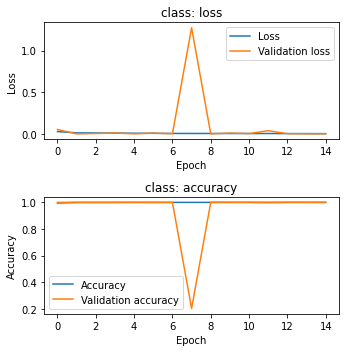

3011/3011 [==============================] - 29s 9ms/step


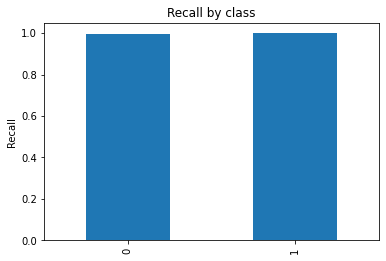

Classification report
              precision    recall  f1-score   support

    abnormal       0.96      0.99      0.98      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.98      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.00670540239661932, accuracy: 0.9986919164657593


In [ ]:
modelBN_accuracy, modelBN_precision, modelBN_recall, modelBN_f1 = utils.eval_model(trainingBN, modelBN, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [ ]:
name='ModelWithBN'

"""
Generate data Kaggle
"""
#generate kaggle
utils.load_test_sequences_and_generate_prediction_file(modelBN, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelBN.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelBN.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

5931/5931 [==============================] - 55s 9ms/step
Saved model to disk


### Modelo Mejorado con Gradient Clipping


In [ ]:
optimizer = Adam(clipvalue=0.5) #para agregar clip value clipvalue=0.5

In [ ]:
modelGC = Sequential()
modelGC.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
modelGC.add(LSTM(units, return_sequences=True))
modelGC.add(LSTM(units, return_sequences=False))
modelGC.add(Dense(2, activation='softmax'))
modelGC.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelGC.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 19, 3)             90        
                                                                 
 lstm_12 (LSTM)              (None, 19, 72)            21888     
                                                                 
 lstm_13 (LSTM)              (None, 72)                41760     
                                                                 
 dense_8 (Dense)             (None, 2)                 146       
                                                                 
Total params: 63,884
Trainable params: 63,884
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento

In [ ]:
#se agregó class.weights
trainingGC, modelGC = utils.train(modelGC,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/15
8390/8390 [==============================] - 251s 29ms/step - loss: 0.0736 - accuracy: 0.9892 - precision_2: 0.9892 - recall_2: 0.9892 - val_loss: 0.0095 - val_accuracy: 0.9987 - val_precision_2: 0.9987 - val_recall_2: 0.9987
Epoch 2/15
8390/8390 [==============================] - 247s 29ms/step - loss: 0.0183 - accuracy: 0.9979 - precision_2: 0.9979 - recall_2: 0.9979 - val_loss: 0.0149 - val_accuracy: 0.9985 - val_precision_2: 0.9985 - val_recall_2: 0.9985
Epoch 3/15
8390/8390 [==============================] - 250s 30ms/step - loss: 0.0184 - accuracy: 0.9981 - precision_2: 0.9981 - recall_2: 0.9981 - val_loss: 0.0050 - val_accuracy: 0.9988 - val_precision_2: 0.9988 - val_recall_2: 0.9988
Epoch 4/15
8390/8390 [==============================] - 249s 30ms/step - loss: 0.0121 - accuracy: 0.9988 - precision_2: 0.9988 - recall_2: 0.9988 - val_loss: 0.0093 - val_accuracy: 0.9979 - val_precision_2: 0.9979 - val_recall_2: 0.9979
Epoch 5/15
8390/8390 [==============================

#### Evaluación

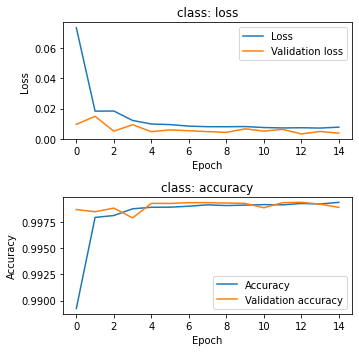

3011/3011 [==============================] - 34s 11ms/step


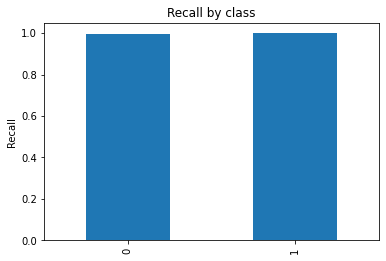

Classification report
              precision    recall  f1-score   support

    abnormal       0.96      0.99      0.98      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.98      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.004157017916440964, accuracy: 0.9986607432365417


In [ ]:
modelGC_accuracy, modelGC_precision, modelGC_recall, modelGC_f1 = utils.eval_model(trainingGC, modelGC, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [ ]:
name='ModelWithGC'

"""
Generate data Kaggle
"""
#generate kaggle
utils.load_test_sequences_and_generate_prediction_file(modelGC, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelGC.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelGC.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")


5931/5931 [==============================] - 57s 10ms/step
Saved model to disk


### Modelo Mejorado con Gradient *Normalization*




In [ ]:
optimizer = Adam(clipnorm=1.) #para agregar clip value clipvalue=0.5

In [ ]:
modelGN = Sequential()
modelGN.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
modelGN.add(LSTM(units, return_sequences=True))
modelGN.add(LSTM(units, return_sequences=False))
modelGN.add(Dense(2, activation='softmax'))
modelGN.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelGN.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 19, 3)             90        
                                                                 
 lstm_14 (LSTM)              (None, 19, 72)            21888     
                                                                 
 lstm_15 (LSTM)              (None, 72)                41760     
                                                                 
 dense_9 (Dense)             (None, 2)                 146       
                                                                 
Total params: 63,884
Trainable params: 63,884
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento

In [ ]:
#se agregó class.weights
trainingGN, modelGN = utils.train(modelGN,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/15
8390/8390 [==============================] - 255s 30ms/step - loss: 0.1446 - accuracy: 0.9840 - precision_3: 0.9840 - recall_3: 0.9840 - val_loss: 0.0132 - val_accuracy: 0.9983 - val_precision_3: 0.9983 - val_recall_3: 0.9983
Epoch 2/15
8390/8390 [==============================] - 251s 30ms/step - loss: 0.0270 - accuracy: 0.9985 - precision_3: 0.9985 - recall_3: 0.9985 - val_loss: 0.0153 - val_accuracy: 0.9988 - val_precision_3: 0.9988 - val_recall_3: 0.9988
Epoch 3/15
8390/8390 [==============================] - 250s 30ms/step - loss: 0.0205 - accuracy: 0.9987 - precision_3: 0.9987 - recall_3: 0.9987 - val_loss: 0.0081 - val_accuracy: 0.9988 - val_precision_3: 0.9988 - val_recall_3: 0.9988
Epoch 4/15
8390/8390 [==============================] - 251s 30ms/step - loss: 0.0170 - accuracy: 0.9988 - precision_3: 0.9988 - recall_3: 0.9988 - val_loss: 0.0069 - val_accuracy: 0.9988 - val_precision_3: 0.9988 - val_recall_3: 0.9988
Epoch 5/15
8390/8390 [==============================

#### Evaluación

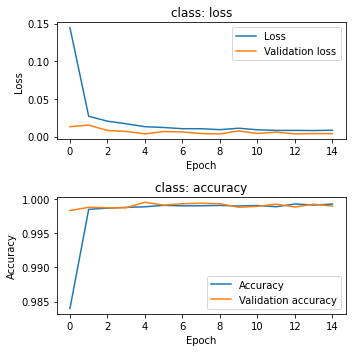

3011/3011 [==============================] - 30s 10ms/step


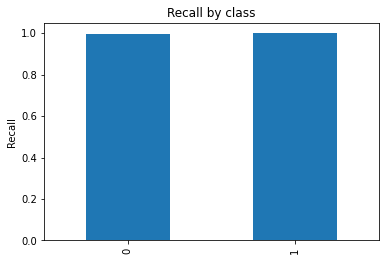

Classification report
              precision    recall  f1-score   support

    abnormal       0.97      0.99      0.98      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.99      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.003814506810158491, accuracy: 0.9989306926727295


In [ ]:
modelGN_accuracy, modelGN_precision, modelGN_recall, modelGN_f1 = utils.eval_model(trainingGN, modelGN, X_test, y_test)

####Generación modelo y Salida Kaggle

In [ ]:
name='ModelWithGN'

"""
Generate data Kaggle
"""
#generate kaggle
utils.load_test_sequences_and_generate_prediction_file(modelGN, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelGN.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelGN.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")


5931/5931 [==============================] - 59s 10ms/step
Saved model to disk


### Modelo Mejorado con Batch Normalization y Gradient Normalization

In [ ]:
modelGN_BN = Sequential()
modelGN_BN.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
modelGN_BN.add(LSTM(units, return_sequences=True))
modelGN_BN.add(LSTM(units, return_sequences=False))
modelGN_BN.add(BatchNormalization())
modelGN_BN.add(Dense(2, activation='softmax'))
modelGN_BN.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelGN_BN.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 19, 3)             90        
                                                                 
 lstm_16 (LSTM)              (None, 19, 72)            21888     
                                                                 
 lstm_17 (LSTM)              (None, 72)                41760     
                                                                 
 batch_normalization_1 (Batc  (None, 72)               288       
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 2)                 146       
                                                                 
Total params: 64,172
Trainable params: 64,028
Non-trainable params: 144
_______________________________________________

#### Entrenamiento

In [ ]:
#se agregó class.weights
trainingGN_BN, modelGN_BN = utils.train(modelGN_BN,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/15
8390/8390 [==============================] - 267s 31ms/step - loss: 0.0372 - accuracy: 0.9978 - precision_4: 0.9978 - recall_4: 0.9978 - val_loss: 4.6612 - val_accuracy: 0.0304 - val_precision_4: 0.0304 - val_recall_4: 0.0304
Epoch 2/15
8390/8390 [==============================] - 258s 31ms/step - loss: 0.0249 - accuracy: 0.9991 - precision_4: 0.9991 - recall_4: 0.9991 - val_loss: 0.0048 - val_accuracy: 0.9992 - val_precision_4: 0.9992 - val_recall_4: 0.9992
Epoch 3/15
8390/8390 [==============================] - 261s 31ms/step - loss: 0.0239 - accuracy: 0.9990 - precision_4: 0.9990 - recall_4: 0.9990 - val_loss: 16.1115 - val_accuracy: 0.0277 - val_precision_4: 0.0277 - val_recall_4: 0.0277
Epoch 4/15
8390/8390 [==============================] - 260s 31ms/step - loss: 0.0271 - accuracy: 0.9992 - precision_4: 0.9992 - recall_4: 0.9992 - val_loss: 2.9665 - val_accuracy: 0.0302 - val_precision_4: 0.0302 - val_recall_4: 0.0302
Epoch 5/15
8390/8390 [=============================

#### Evaluación

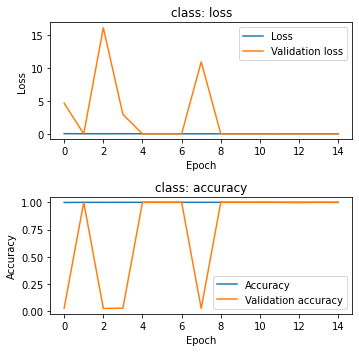

3011/3011 [==============================] - 29s 9ms/step


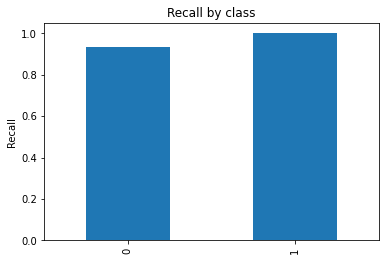

Classification report
              precision    recall  f1-score   support

    abnormal       0.99      0.93      0.96      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       1.00      0.97      0.98     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.008764299564063549, accuracy: 0.9978302121162415


In [ ]:
modelGN_BN_accuracy, modelGN_BN_precision, modelGN_BN_recall, modelGN_BN_f1 = utils.eval_model(trainingGN_BN, modelGN_BN, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [ ]:
name='ModelWithGNandBN'

"""
Generate data Kaggle
"""

utils.load_test_sequences_and_generate_prediction_file(modelGN_BN, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelGN_BN.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelGN_BN.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

5931/5931 [==============================] - 56s 9ms/step
Saved model to disk


### Modelo Mejorado con Data Augmentation

In [ ]:
modelDA = Sequential()
modelDA.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
modelDA.add(LSTM(units, return_sequences=True))
modelDA.add(LSTM(units, return_sequences=False))
modelDA.add(Dense(2, activation='softmax'))
modelDA.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelDA.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 19, 3)             90        
                                                                 
 lstm_18 (LSTM)              (None, 19, 72)            21888     
                                                                 
 lstm_19 (LSTM)              (None, 72)                41760     
                                                                 
 dense_11 (Dense)            (None, 2)                 146       
                                                                 
Total params: 63,884
Trainable params: 63,884
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento

In [ ]:
#se agregó class.weights
trainingDA, modelDA = utils.train(modelDA,
                X_train_aug,
                y_train_aug, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/15
14850/14850 [==============================] - 445s 30ms/step - loss: 0.2395 - accuracy: 0.9865 - precision_5: 0.9865 - recall_5: 0.9865 - val_loss: 0.1040 - val_accuracy: 0.9992 - val_precision_5: 0.9992 - val_recall_5: 0.9992
Epoch 2/15
14850/14850 [==============================] - 443s 30ms/step - loss: 0.2089 - accuracy: 0.9935 - precision_5: 0.9935 - recall_5: 0.9935 - val_loss: 0.0997 - val_accuracy: 0.9963 - val_precision_5: 0.9963 - val_recall_5: 0.9963
Epoch 3/15
14850/14850 [==============================] - 441s 30ms/step - loss: 0.2042 - accuracy: 0.9933 - precision_5: 0.9933 - recall_5: 0.9933 - val_loss: 0.0929 - val_accuracy: 0.9989 - val_precision_5: 0.9989 - val_recall_5: 0.9989
Epoch 4/15
14850/14850 [==============================] - 439s 30ms/step - loss: 0.2022 - accuracy: 0.9902 - precision_5: 0.9902 - recall_5: 0.9902 - val_loss: 0.0955 - val_accuracy: 0.9988 - val_precision_5: 0.9988 - val_recall_5: 0.9988
Epoch 5/15
14850/14850 [====================

#### Evaluación

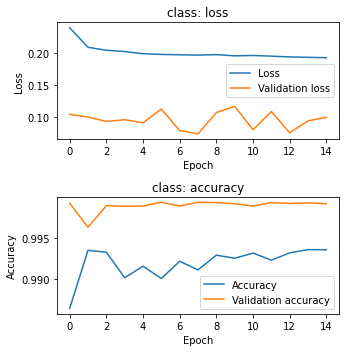

3011/3011 [==============================] - 28s 9ms/step


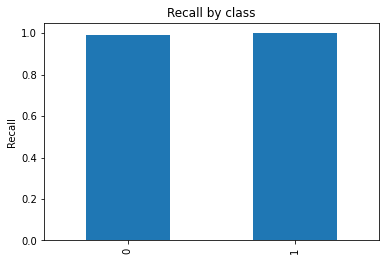

Classification report
              precision    recall  f1-score   support

    abnormal       0.98      0.99      0.99      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.99      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.0988328605890274, accuracy: 0.9991175532341003


In [ ]:
modelDA_accuracy, modelDA_precision, modelDA_recall, modelDA_f1 = utils.eval_model(trainingDA, modelDA, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [ ]:
name='ModelWithDataAugmentation'

"""
Generate data Kaggle
"""

utils.load_test_sequences_and_generate_prediction_file(modelDA, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelDA.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelDA.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

5931/5931 [==============================] - 56s 10ms/step
Saved model to disk


### Modelo Mejorado con Data Augmentation y Gradient Normalization 

In [ ]:
optimizer = Adam(clipnorm=1.) #para agregar clip value clipvalue=0.5

In [ ]:
modelGN_DA = Sequential()
modelGN_DA.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN)) 
modelGN_DA.add(LSTM(units, return_sequences=True))
modelGN_DA.add(LSTM(units, return_sequences=False))
modelGN_DA.add(Dense(2, activation='softmax'))
modelGN_DA.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelGN_DA.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 19, 3)             90        
                                                                 
 lstm_20 (LSTM)              (None, 19, 72)            21888     
                                                                 
 lstm_21 (LSTM)              (None, 72)                41760     
                                                                 
 dense_12 (Dense)            (None, 2)                 146       
                                                                 
Total params: 63,884
Trainable params: 63,884
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento

In [ ]:
trainingGN_DA, modelGN_DA = utils.train(modelGN_DA,
                X_train_aug,
                y_train_aug, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/15
14850/14850 [==============================] - 445s 30ms/step - loss: 0.2466 - accuracy: 0.9869 - precision_6: 0.9869 - recall_6: 0.9869 - val_loss: 0.1060 - val_accuracy: 0.9990 - val_precision_6: 0.9990 - val_recall_6: 0.9990
Epoch 2/15
14850/14850 [==============================] - 437s 29ms/step - loss: 0.2165 - accuracy: 0.9918 - precision_6: 0.9918 - recall_6: 0.9918 - val_loss: 0.0993 - val_accuracy: 0.9987 - val_precision_6: 0.9987 - val_recall_6: 0.9987
Epoch 3/15
14850/14850 [==============================] - 444s 30ms/step - loss: 0.2085 - accuracy: 0.9927 - precision_6: 0.9927 - recall_6: 0.9927 - val_loss: 0.0903 - val_accuracy: 0.9987 - val_precision_6: 0.9987 - val_recall_6: 0.9987
Epoch 4/15
14850/14850 [==============================] - 448s 30ms/step - loss: 0.2018 - accuracy: 0.9917 - precision_6: 0.9917 - recall_6: 0.9917 - val_loss: 0.0907 - val_accuracy: 0.9993 - val_precision_6: 0.9993 - val_recall_6: 0.9993
Epoch 5/15
14850/14850 [====================

#### Evaluación

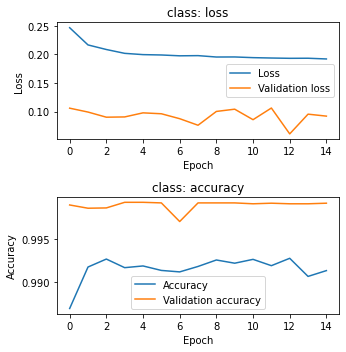

3011/3011 [==============================] - 28s 9ms/step


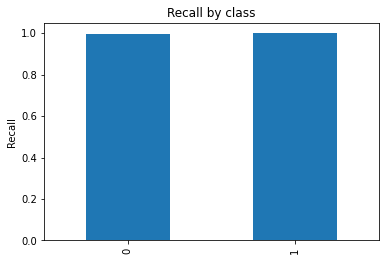

Classification report
              precision    recall  f1-score   support

    abnormal       0.98      0.99      0.99      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.99      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.09232813119888306, accuracy: 0.9991382956504822


In [ ]:
modelGN_DA_accuracy, modelGN_DA_precision, modelGN_DA_recall, modelGN_DA_f1 = utils.eval_model(trainingGN_DA, modelGN_DA, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [ ]:
name='ModelWithDataAugmentationAndGradientNormalization'

"""
Generate data Kaggle
"""

utils.load_test_sequences_and_generate_prediction_file(modelGN_DA, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelGN_DA.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelGN_DA.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

5931/5931 [==============================] - 54s 9ms/step
Saved model to disk


## Conclusiones y reflexiones finales

## Bibliogafìía y referencias

In [ ]:
pd.options.display.float_format = '{:.3%}'.format
data = [['Initial Model',initialmodel_accuracy, initialmodel_precision, initialmodel_recall, initialmodel_f1], ['Improved Model',improved_model_accuracy, improved_model_precision, improved_model_recall, improved_model_f1], ['Improved Model Grid Search',model_accuracy, model_precision, model_recall, model_f1], ['Improved Model Grid Search with BN',modelBN_accuracy, modelBN_precision, modelBN_recall, modelBN_f1], ['Improved Model Grid Search with GC',modelGC_accuracy, modelGC_precision, modelGC_recall, modelGC_f1], ['Improved Model Grid Search with GN',modelGN_accuracy, modelGN_precision, modelGN_recall, modelGN_f1], ['Improved Model Grid Search with BN & GN',modelGN_BN_accuracy, modelGN_BN_precision, modelGN_BN_recall, modelGN_BN_f1], ['Improved Model Grid Search with DA',modelDA_accuracy, modelDA_precision, modelDA_recall, modelDA_f1], ['Improved Model Grid Search with DA & GN',modelGN_DA_accuracy, modelGN_DA_precision, modelGN_DA_recall, modelGN_DA_f1]]
pd.DataFrame(data, columns=["Modelo", "Accuracy", "Precision","Recall","F1-score"]).sort_values(by='F1-score', ascending=False)

,Modelo,Accuracy,Precision,Recall,F1-score
8,Improved Model Grid Search with DA & GN,99.914%,98.872%,99.672%,99.269%
7,Improved Model Grid Search with DA,99.912%,98.870%,99.637%,99.251%
0,Initial Model,99.899%,98.688%,99.614%,99.146%
5,Improved Model Grid Search with GN,99.893%,98.512%,99.694%,99.096%
2,Improved Model Grid Search,99.871%,98.172%,99.683%,98.915%
1,Improved Model,99.871%,98.202%,99.650%,98.915%
3,Improved Model Grid Search with BN,99.869%,98.140%,99.682%,98.898%
4,Improved Model Grid Search with GC,99.866%,98.122%,99.647%,98.872%
6,Improved Model Grid Search with BN & GN,99.783%,99.568%,96.698%,98.088%
